# Ni and Fe microspectrocopy data from BNL

1. **Fe_xanes** (from HXN) is a model system sample used for optimizing nano-XANES workflow. We know the "true value" chemical state map. The aggregate is composed of 
        a. LiFe(II)PO4 (LFP)

        b. Pyrite (Pyr)

        c. StainlessSteelNP (SS) and

        d. Hematite_NP (Hem).

      *Please note that this is unpublished data from a submitted MS*


2. **Ni_xanes** is NMC?

In [1]:
from ipywidgets import IntSlider, widgets, interactive, fixed

import numpy as np
from scipy.interpolate import interp1d
from scipy.stats import wasserstein_distance, pearsonr

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib import gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl

import selector
from selector import energy_point_selector
from importlib import reload

import utils
utils = reload(utils)
from utils import *

np.random.seed(42)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

## Read in data

(101, 320, 320)
(73, 155, 160)


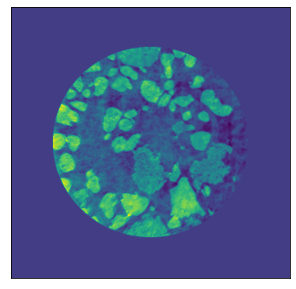

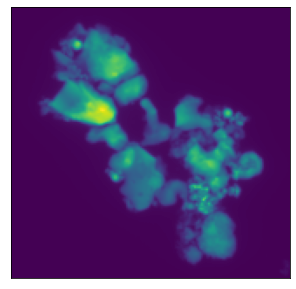

In [3]:
Ni_xanes = parse_tiff('Data/TXM_XANES/Ni_xanes.tiff')
Ni_energy = np.loadtxt('Data/TXM_XANES/Ni_eng_list.txt')

Fe_xanes = parse_tiff('Data/HXN_XANES/nanoXANES_Fe.tiff')
Fe_energy = np.loadtxt('Data/HXN_XANES/energy_list_corr.txt')

def plot_img(data):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(data, extent=[0, 1, 0, 1], aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])

print(Ni_xanes.shape)
print(Fe_xanes.shape)

plot_img(np.average(Ni_xanes, axis=0))
plot_img(np.average(Fe_xanes, axis=0))

In [4]:
def plot_spectra(i, Data):
    fig, ax = plt.subplots(figsize=(5, 5))    
    data = Data[i]
    ax.imshow(data, extent=[0, 1, 0, 1], aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
        

data = Fe_xanes
slider = IntSlider(min=0, max=len(data) - 1, step=1, value=0,
                   layout=widgets.Layout(width='50%'))
interactive(plot_spectra, i=slider, Data=fixed(data))

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='50%'), max=72), Output()), _dom…

# Iron References

## Interpolating Fe XANES and Refs onto same energy grid

In [5]:
ref_energy, Refs_dict, Refs_raw = parse_nor('Data/HXN_XANES/FeLibNov2021.nor')
energy = np.linspace(7090, 7196, 54)

interperlator = interp1d(ref_energy, Refs_raw)
Refs = interperlator(energy)

Fe_xanes_tmp = np.zeros((len(energy), Fe_xanes.shape[1], Fe_xanes.shape[2]))
for x in range(Fe_xanes.shape[1]):
    for y in range(Fe_xanes.shape[2]):
        interperlator = interp1d(Fe_energy, Fe_xanes[:, x, y])
        Fe_xanes_tmp[:, x, y] = interperlator(energy)

Fe_xanes = Fe_xanes_tmp
Fe_energy = energy

(12, 196)


# Some visualization

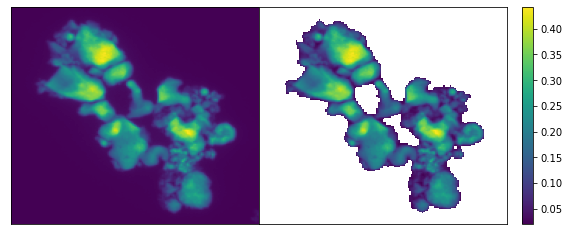

In [6]:
data = Fe_xanes

fig = plt.figure(figsize=(10, 4))
spec = fig.add_gridspec(ncols=2, width_ratios=[0.8, 1.])
plt.subplots_adjust(wspace=0.)

ax = fig.add_subplot(spec[0])
ax.imshow(np.max(data, axis=0), extent=[0, 1, 0, 1], aspect='auto')
ax = fig.add_subplot(spec[1])
img = ax.imshow(np.max(get_filtered_img(data), axis=0), extent=[0, 1, 0, 1], aspect='auto')

for ax in fig.get_axes():
    remove_ticks(ax)

plt.colorbar(img)
plt.show()

In [7]:
%matplotlib inline

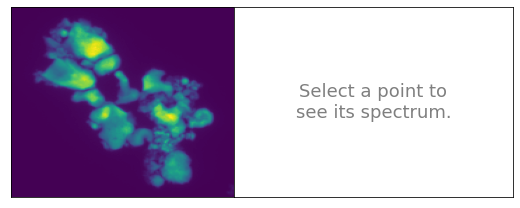

In [8]:
data = Fe_xanes

fig = plt.figure(figsize=(9, 3.5))
spec = fig.add_gridspec(ncols=2, width_ratios=[0.8, 1.])
plt.subplots_adjust(wspace=0.)

ax = fig.add_subplot(spec[0])
img = ax.imshow(np.max(data, axis=0), extent=[0, 1, 0, 1], aspect='auto')

ax = fig.add_subplot(spec[1])
ax.text(0.5, 0.5, "Select a point to\nsee its spectrum.", fontsize=18, ha='center', va='center',
        c=plt.cm.tab10(7))

for ax in fig.get_axes():
    remove_ticks(ax)

add_point_label(img, data, ax)

# Step 1. Filter out background, i.e., space with no sample

In [6]:
data = Fe_xanes
energy = Fe_energy

fd, mask = get_filtered_img(data, return_mask=True)

filtered_spectra_dict = {}
for x in range(fd.shape[1]):
    for y in range(fd.shape[2]):
        if mask[0, x, y] == False:
            spectrum = fd[:, x, y]
            filtered_spectra_dict[(x, y)] = spectrum
filtered_spectra = np.array(list(filtered_spectra_dict.values()))

# Step 2. Normalize experimental spectra

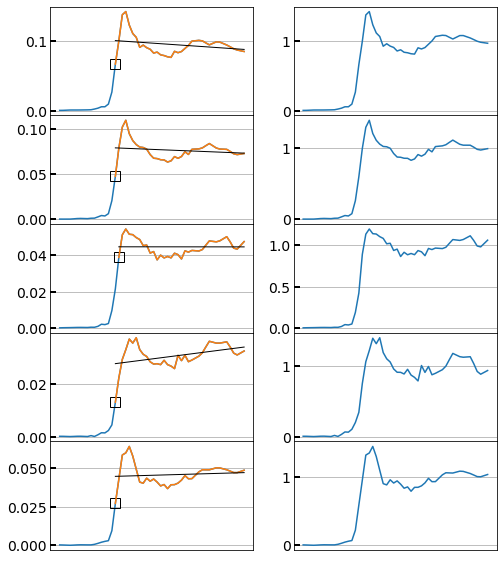

In [7]:
slopes, intercepts, whitelines = show_normalization(energy, filtered_spectra, N=5, return_params=True)

In [7]:
normalized_spectra, normalized_spectra_dict = normalize_spectra(energy,
                                                                filtered_spectra,
                                                                filtered_spectra_dict)

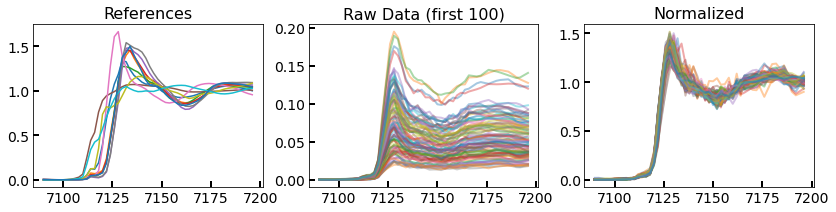

In [9]:
fig, axes = plt.subplots(figsize=(14, 3), ncols=3)
plt.subplots_adjust(wspace=0.2)

for r in Refs:
    axes[0].plot(energy, r)
    
c = 0
for i, spectrum in enumerate(filtered_spectra):
    axes[1].plot(energy, spectrum, linewidth=2, alpha=0.4)
    axes[2].plot(energy, normalized_spectra[i], linewidth=2, alpha=0.4)
    c += 1
    if c > 100:
        break

titles = ['References', 'Raw Data (first 100)', 'Normalized']

for i, ax in enumerate(axes):
    ax.set_title(titles[i], fontsize=16)
    ax.tick_params(direction='in', width=2, length=6, labelsize=14)

# Step 3. Cluster Spectra
# PIPELINE: PCA --> UMAP --> dbscan --> clustering

It takes 9 PCs to explain 95% variance.


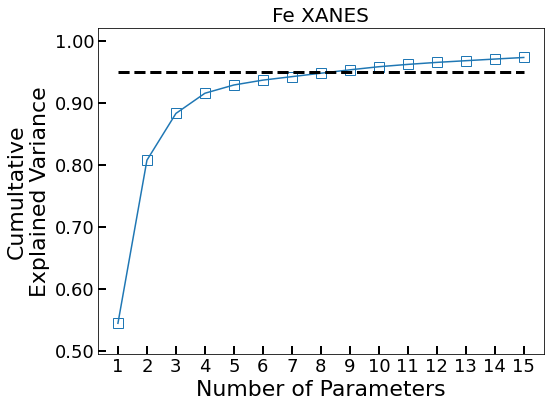

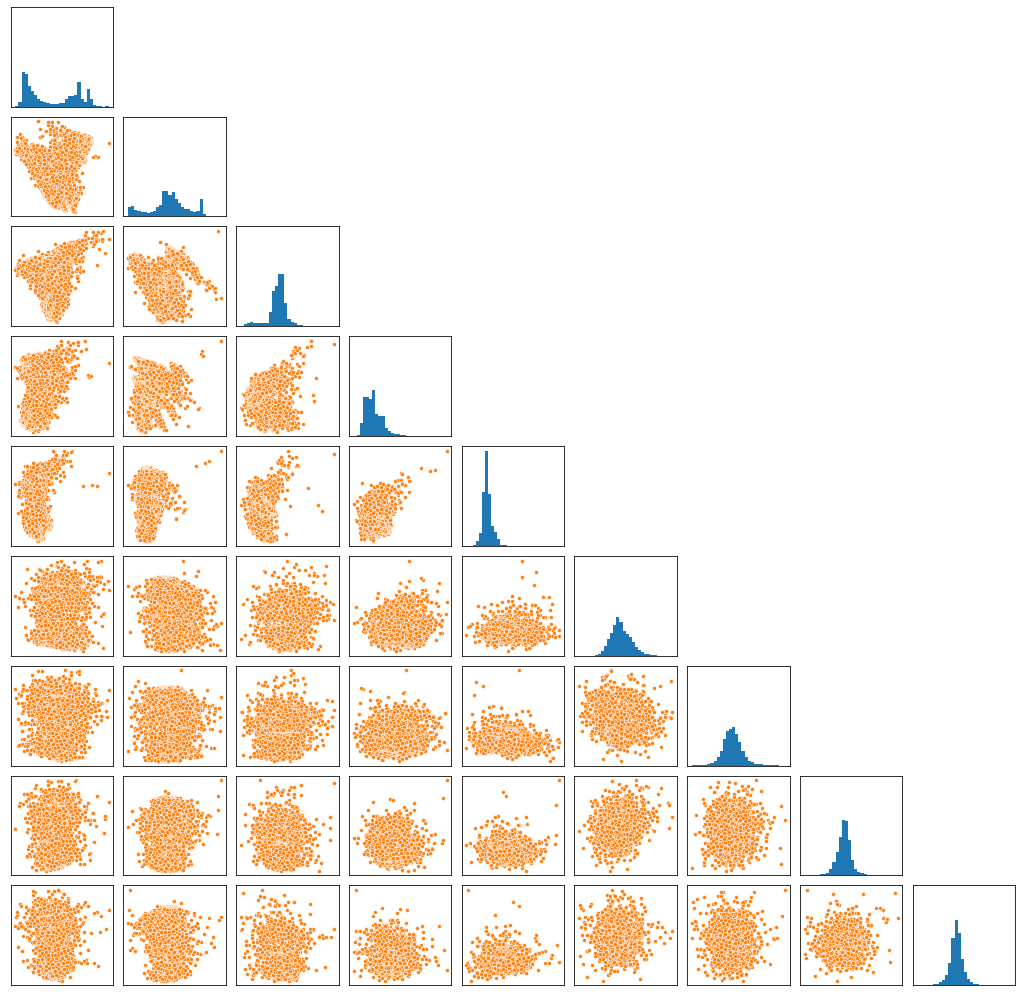

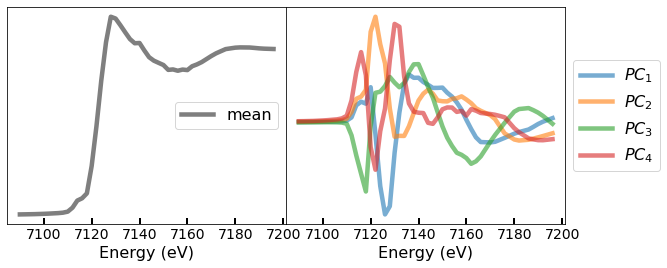

6 -> 6
0 -> 16
1 -> 17
7 -> 13
3 -> 18
2 -> 7
5 -> 12
4 -> 19


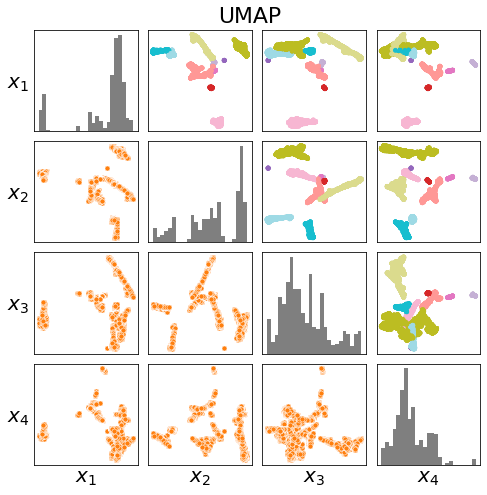

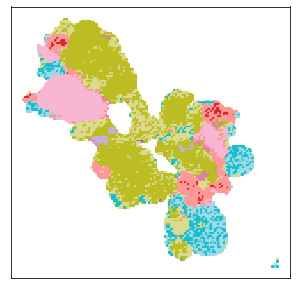

In [10]:
# PCA
n_components = make_scree_plot(normalized_spectra, n=15, c=0, threshold=0.95, show_first_PC=False)
plt.title('Fe XANES', fontsize=20)
plt.show()

pca, pca_components = make_PCA_traingle_plot(normalized_spectra, n_components)

show_PCs(energy, pca, n=4)

# UMAP & dbscan
color_labels, codemap, dbscan_clustering = make_UMAP_plot(pca_components, normalized_spectra_dict,
                                                          n_neighbors=4.5, min_dist=0, dimension=4)

# Final clusters
plot_color_code_map(normalized_spectra_dict, color_labels)

# Step 4. LCF

### First find cluster averages

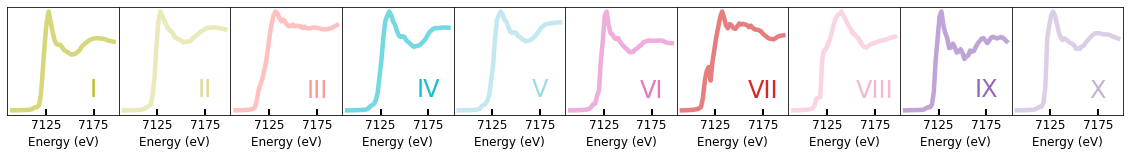

In [11]:
cluster_avgs = get_cluster_avgs(normalized_spectra_dict, color_labels, dbscan_clustering)
plot_cluster_avgs(energy, cluster_avgs, codemap)

## How reliable are Refs fitted onto themselves?

It takes 3 PCs to explain 95% variance.


3

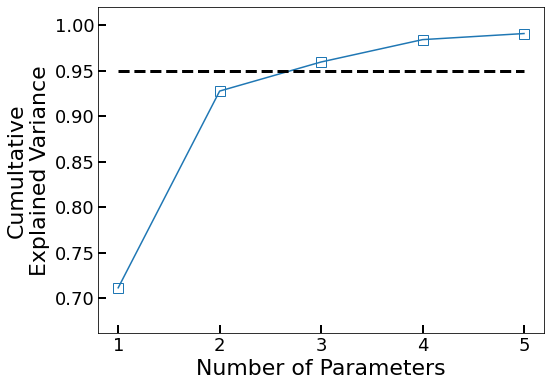

In [11]:
make_scree_plot(Refs, threshold=.95, show_first_PC=False)

In [14]:
subset_size = 5
subset_indices, subsets, scales, coeffs, scores = [], [], [], [], []
targets = Refs 
for i in range(len(targets)):
    sub_idxs, subset, scale, coeffs_hat, score = LCF(targets[i], targets, subset_size,
                                                     lambda1=0.1, lambda2=1e8)
    subset_indices.append(sub_idxs)
    subsets.append(subset)
    coeffs.append(coeffs_hat)
    scales.append(scale)
    scores.append(score)

[ 0  4  7  8 10] 3.466318526650637e-06
[ 1  2  3  5 10] 5.005428072044559e-06
[0 1 2 3 6] 2.0282381242822425e-07
[0 1 3 5 8] 2.497991488582963e-07
[0 1 2 4 9] 1.6191691113566053e-07
[0 1 3 5 8] 1.507634482056009e-06
[0 1 5 6 8] 4.707492769370045e-06
[0 3 5 6 7] 1.1623983883009635e-06
[2 3 4 6 8] 7.749532522560516e-06
[2 3 6 7 9] 1.4038378160619138e-05
[ 0  2  5  9 10] 3.257460832796038e-08


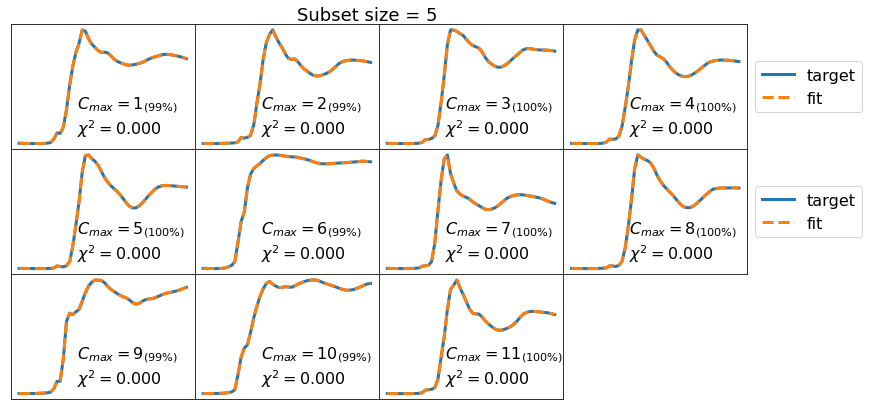

In [15]:
plot_recon_grid(energy, targets, subset_indices, subsets, scales, coeffs, Refs_dict,
                verbose=True, ncols=4, c=1)              
plt.suptitle(f'Subset size = {subset_size}', fontsize=18, y=.88, va='bottom')
plt.show()

## Cluster averages fit to Refs

In [12]:
subset_size = 4
subset_indices, subsets, scales, coeffs, scores = [], [], [], [], []
targets = np.array(list(cluster_avgs.values()))
for i in range(len(targets)):
    sub_idxs, subset, scale, coeffs_hat, score = LCF(targets[i], Refs, subset_size,
                                                     lambda1=0.1, lambda2=1e8)
    subset_indices.append(sub_idxs)
    subsets.append(subset)
    scales.append(scale)
    coeffs.append(coeffs_hat)
    scores.append(score)

[2 5 6 9] 0.09670246751379875
[2 5 6 9] 0.08809885574821305
[ 6  7  9 10] 0.01302846530696814
[ 2  8  9 10] 0.06602958626956693
[2 4 6 9] 0.12483906308793895
[ 2  6  9 10] 0.02494783788418414
[0 5 7 9] 0.19708096253435567
[5 6 7 8] 0.2350945868954514
[2 5 6 9] 0.15773586407017157
[6 7 8 9] 0.10246609654325205


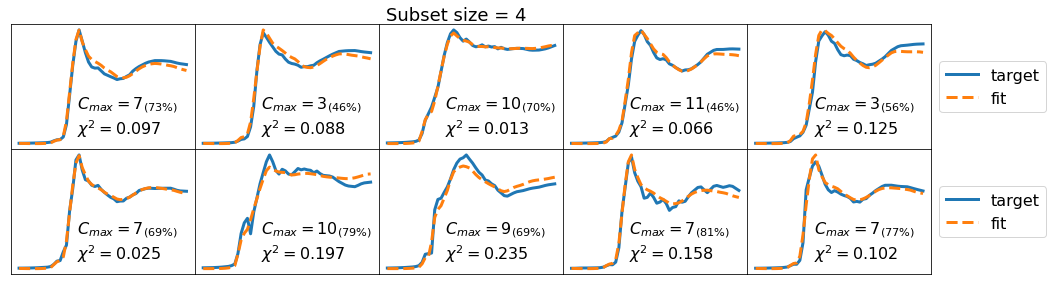

In [13]:
plot_recon_grid(energy, targets, subset_indices, subsets, scales, coeffs, Refs_dict,
                ncols=5, flag_identity=False, c=1)              
plt.suptitle(f'Subset size = {subset_size}', fontsize=18, y=.88, va='bottom')
plt.show()

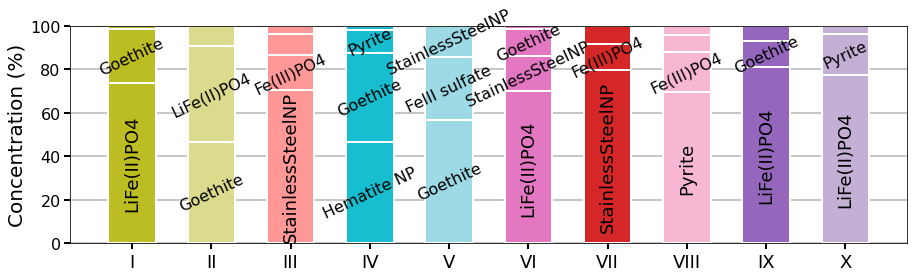

In [14]:
fig, ax = plt.subplots(figsize=(len(cluster_avgs) * 1.5, 4))
plot_conc_from_subset((fig, ax), np.array(coeffs).reshape(len(coeffs), -1),
                      list(Refs_dict.keys()), subset_indices, codemap)

# PART II. Recursive Feature Elimination

In [21]:
energy_point_selector = reload(selector.energy_point_selector)

In [234]:
best_estimator = 'Random Forest'
best_n = 5
Is = []

reps = 500
for i in range(reps):
    print(i, end='\r')
    kwargs = {'N': 10, 'scale': 0.0, 'dropout': 0.85}
    data, coeffs = generate_linear_combos(Refs, **kwargs)
    
    select = energy_point_selector.Selector(data, coeffs)
    rfe = select.select_energy_points(estimator=best_estimator, n_points=best_n,
                                      verbose=False, scoring='neg_root_mean_squared_error',
                                      n_estimators=50)
    energy_measurements = energy[rfe.support_]
    indices = [i for i, e in enumerate(energy) if e in energy_measurements]
    Is.append(indices)
Is = np.array(Is)

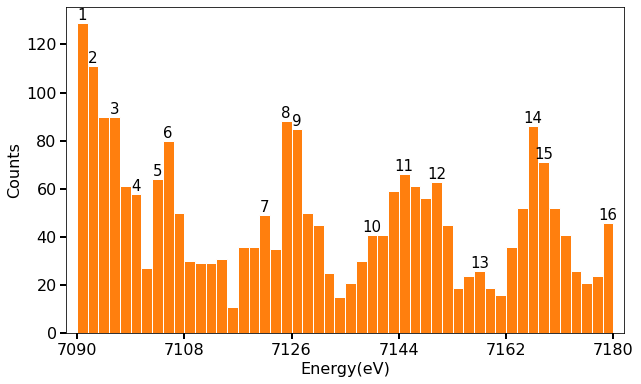

In [271]:
fig, ax = plt.subplots(figsize=(10, 6))
indices = [0, 1, 3, 5, 7, 8, 17, 19, 20, 27, 30, 33, 37, 42, 43, 49]
labels = np.arange(1, len(indices) + 1)
label_map = {idx: label for idx, label in zip(indices, labels)}
histogram_of_importance((fig, ax), Is.reshape(-1), energy, label_map=label_map)
plt.show()

# Back to the pipeline on energy subset
## Step 1. Slice energies

In [8]:
indices = [0, 1, 3, 5, 7, 8, 17, 19, 20, 27, 30, 33, 37, 42, 43, 49]
energy_subset = np.array(energy[indices])
Y_Refs = Refs[:, indices]

prenormalized_subset = np.array(normalized_spectra)[:, indices]

data_subset = np.array(filtered_spectra)[:, indices]
postnormalized_subset, postnormalized_subset_dict = normalize_spectra(energy_subset,
                                                                      data_subset,
                                                                      filtered_spectra_dict)

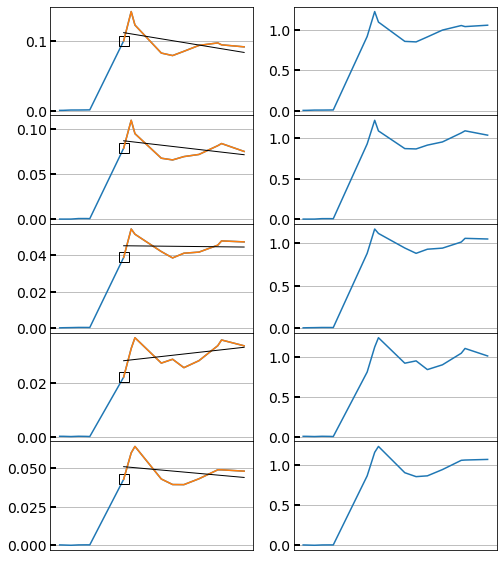

In [13]:
sub_slopes, sub_intercepts, sub_whitelines = show_normalization(energy_subset, data_subset,
                                                                N=5, return_params=True)

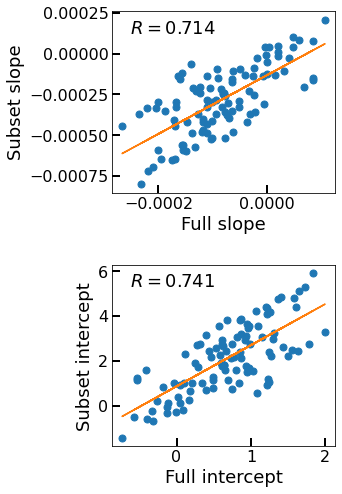

In [18]:
N = 100
slopes, intercepts, whitelines = show_normalization(energy, filtered_spectra,
                                                    N=N, return_params=True, plot=False)
sub_slopes, sub_intercepts, sub_whitelines = show_normalization(energy_subset, data_subset,
                                                                N=N, return_params=True, plot=False)

fig, axes = plt.subplots(figsize=(4, 8), nrows=2)
plt.subplots_adjust(hspace=0.4)

def plot_corr(x1, x2, ax):
    ax.plot(x1, x2, 'o', markersize=7)

    reg = LinearRegression().fit(x1.reshape(-1, 1), x2.reshape(-1, 1))
    y_fit = reg.predict(x1.reshape(-1, 1)).reshape(-1)
    ax.plot(x1, y_fit, '-')

    x = np.linspace(min(x1), max(x1), 10)
    #ax.plot(x, x, '--', c='k')
    
    R, pval = pearsonr(x1, x2)
    ax.text(0.08, 0.88, f'$R={R:.3f}$', transform=ax.transAxes, fontsize=18)

plot_corr(slopes, sub_slopes, axes[0])
plot_corr(intercepts, sub_intercepts, axes[1])

variables = ['slope', 'intercept']
for i, ax in enumerate(axes):
    ax.set_ylabel(f'Subset {variables[i]}', fontsize=18)
    ax.set_xlabel(f'Full {variables[i]}', fontsize=18)
    ax.tick_params(direction='in', width=2, length=8, labelsize=16)

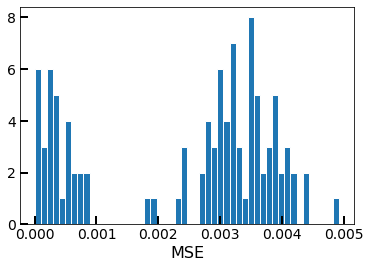

In [19]:
N = 100
plot_recon = False

slopes, intercepts, whitelines = show_normalization(energy, filtered_spectra,
                                                    N=N, return_params=True, plot=False)
sub_slopes, sub_intercepts, sub_whitelines = show_normalization(energy_subset, data_subset,
                                                                N=N, return_params=True, plot=False)

if plot_recon:
    fig, axes = plt.subplots(figsize=(2 * N, 4), ncols=N, nrows=2)
    plt.subplots_adjust(wspace=0, hspace=0)

MSEs = []
for idx in range(N):
    xs = []
    for j, params in enumerate([[slopes[idx], intercepts[idx], whitelines[idx]],
                                [sub_slopes[idx], sub_intercepts[idx], sub_whitelines[idx]]]):
        m, b, w = params
        y_fit = m * energy + b
        
        spectrum = filtered_spectra[idx + 50]
        if j == 0:
            whiteline = w + 1
        else:
            whiteline = indices[w] + 1
        
        y_norm = spectrum.copy()
        offset = y_fit.reshape(-1)[whiteline:]
        y_norm[whiteline:] = y_norm[whiteline:] - offset + spectrum[whiteline + 1]
        y_norm = y_norm / (spectrum[whiteline + 1])
        xs.append(y_norm)
        
        if plot_recon:
            axes[0, idx].plot(energy, y_fit + 1,
                              c=plt.cm.tab20(2 * idx + j), linewidth=3)

            axes[0, idx].axvline(energy[whiteline], linestyle='--', c=plt.cm.tab20(2 * idx + j),
                                 linewidth=2)
            axes[0, idx].set_ylim(min(y_norm), max(y_norm) + 0.1)

            axes[1, idx].plot(energy, y_norm, linestyle='-', c=plt.cm.tab20(2 * idx + j),
                              linewidth=3)
    if plot_recon:
        for ax in axes[:, idx]:
            ax.set_yticks([])
            ax.set_xticks([])
            
    MSEs.append(mean_squared_error(xs[0], xs[1]))
    
if plot_recon == False:
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(MSEs, edgecolor='w', bins=50)
    ax.tick_params(direction='in', width=2, length=8, labelsize=14)
    ax.set_xlabel('MSE', fontsize=16)

## Step 2. Clustering pipeline

It takes 7 PCs to explain 99% variance.


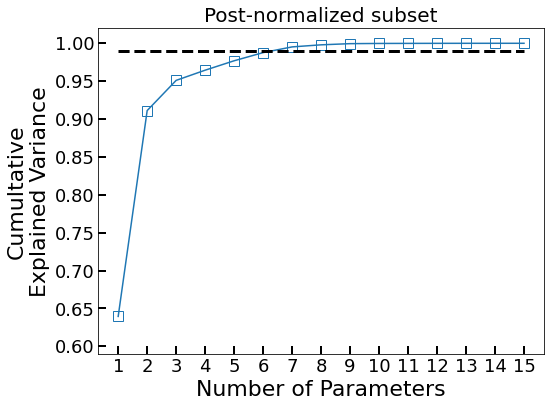

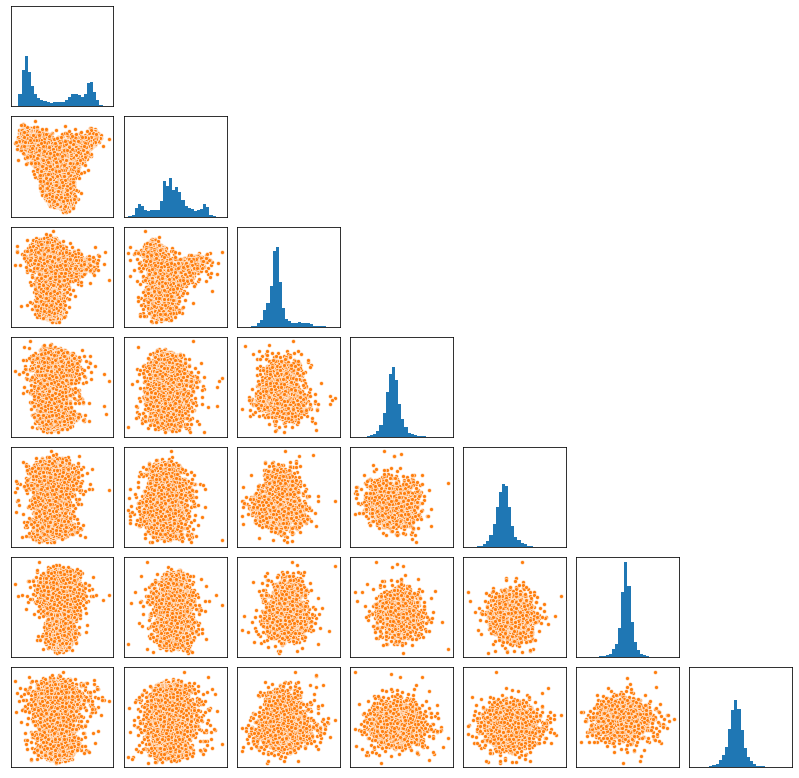

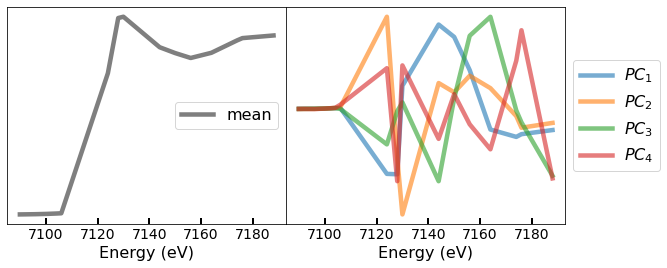

1 -> 6
0 -> 16
0 -> 17
3 -> 13
2 -> 18
1 -> 7
0 -> 12
2 -> 19


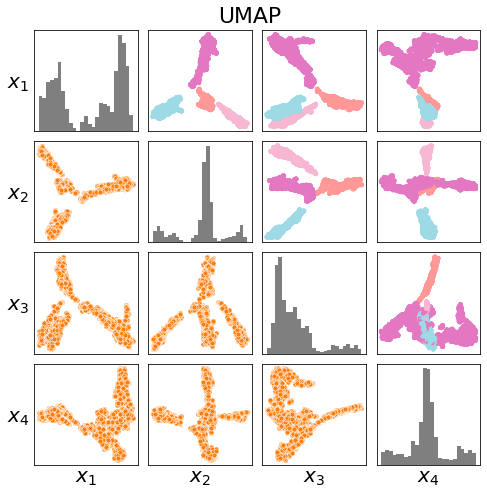

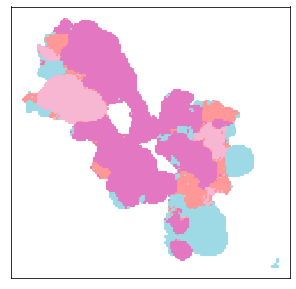

In [9]:
# PCA
n_components_sub = make_scree_plot(postnormalized_subset, n=15, c=0, threshold=0.99, show_first_PC=False)
plt.title('Post-normalized subset', fontsize=20)
plt.show()

pca, pca_components = make_PCA_traingle_plot(postnormalized_subset, n_components_sub)
show_PCs(energy_subset, pca, n=4)

# UMAP
color_labels_sub, codemap_sub, dbscan_clustering_sub = make_UMAP_plot(pca_components, normalized_spectra_dict,
                                                                      n_neighbors=4, min_dist=0, dimension=4,
                                                                      eps=1.)  # eps=1.2, neighs=4, dim=4, thresh=.98

# Final Clusters
plot_color_code_map(normalized_spectra_dict, color_labels_sub)

In [10]:
print(len(np.unique(dbscan_clustering_sub.labels_)))
print(len(np.unique(color_labels_sub)))

4
4


## Step 3. LCF

In [11]:
clusters = {i: [] for i in np.unique(dbscan_clustering_sub.labels_)}

for i, key in enumerate(list(normalized_spectra_dict.keys())):
    spectrum = normalized_spectra_dict[key][indices]
    color = dbscan_clustering_sub.labels_[i]
    clusters[color].append(spectrum)

cluster_avgs = {key: np.average(clusters[key], axis=0) for key in list(clusters.keys())}

In [12]:
subset_size = 4 
subset_indices_sub, subsets_sub, scales_sub, coeffs_sub, scores_sub = [], [], [], [], []
targets = np.array(list(cluster_avgs.values()))
for i in range(len(targets)):
    sub_idxs, subset, scale, coeffs_hat, score = LCF(targets[i], Y_Refs, subset_size,
                                                     lambda1=0.1, lambda2=1e8)
    subset_indices_sub.append(sub_idxs)
    subsets_sub.append(subset)
    scales_sub.append(scale)
    coeffs_sub.append(coeffs_hat)
    scores_sub.append(score)

[2 4 6 9] 0.014337881436074059
[1 4 6 9] 0.00435452589669731
[ 4  6  9 10] 0.014666776110808782
[ 0  7  8 10] 0.032645012602697136


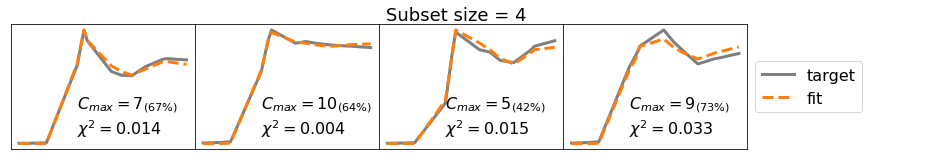

In [13]:
plot_recon_grid(energy_subset, targets, subset_indices_sub, subsets_sub, scales_sub, coeffs_sub, Refs_dict,
                ncols=5, flag_identity=False, c=1)              
plt.suptitle(f'Subset size = {subset_size}', fontsize=18, y=.88, va='bottom')
plt.show()

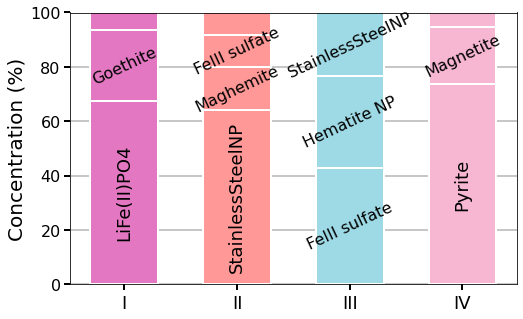

In [14]:
fig, ax = plt.subplots(figsize=(len(cluster_avgs) * 2, 5))
plot_conc_from_subset((fig, ax), np.array(coeffs_sub).reshape(len(coeffs_sub), -1),
                      list(Refs_dict.keys()), subset_indices_sub, codemap_sub)

# Comparing both analyses

In [20]:
def get_cluster_conc(i, dbscan_clustering, subset_indices, N, coeffs):
    cluster = dbscan_clustering.labels_[i]
    concentrations = np.zeros(N)
    for j, index in enumerate(subset_indices[cluster]):
        concentrations[index] = coeffs[cluster, 0, j]
    return concentrations

In [29]:
scores = []
X1 = []
X2 = []
for i in range(len(normalized_spectra)):
    x1 = get_cluster_conc(i, dbscan_clustering, np.array(subset_indices),
                          Refs.shape[0], np.array(coeffs))
    x2 = get_cluster_conc(i, dbscan_clustering_sub, np.array(subset_indices_sub),
                          Y_Refs.shape[0], np.array(coeffs_sub))
    score = wasserstein_distance(x1, x2)
    scores.append(score)
    X1.append(x1)
    X2.append(x2)
scores = np.array(scores)
X1 = np.array(X1)
X2 = np.array(X2)
print(np.average(scores))

0.01878201154309332


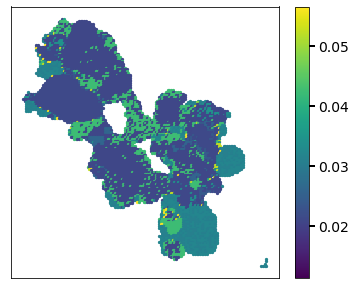

In [31]:
spectra_dict = normalized_spectra_dict
colors = [s / np.max(scores) + np.min(scores) for s in scores]
norm = mpl.colors.Normalize(vmin=np.min(scores), vmax=np.max(scores))

"""
intensities = np.max(filtered_spectra, axis=1)
norm = mpl.colors.Normalize(vmin=np.min(intensities), vmax=np.max(intensities))
intensities = [c / np.max(intensities) + np.min(intensities) for c in intensities]
intensities = np.array(intensities)
colors = intensities
"""

fig, ax = plt.subplots(figsize=(6, 5))
for i, key in enumerate(list(spectra_dict.keys())):
    spectrum = spectra_dict[key]
    x, y = key
    ax.plot(y, -x, marker='.', color=plt.cm.viridis(colors[i]), markersize=4.5)
remove_ticks(ax) 

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis))
cbar.ax.tick_params(direction='out', width=2, length=6, labelsize=14)
plt.show()

# Analysis within clusters -- does LCF accuracy improve when filtering out for each cluster?

In [15]:
utils = reload(utils)
from utils import *

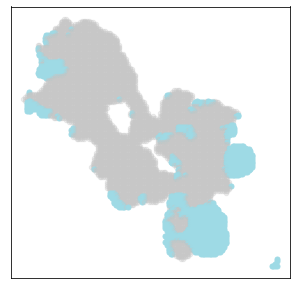

In [16]:
plot_color_code_map(normalized_spectra_dict, color_labels_sub, show_cluster=19)

In [17]:
select_cluster = 19

sub_cluster_data = []
for i, key in enumerate(list(normalized_spectra_dict.keys())):
    spectrum = normalized_spectra_dict[key][indices]
    label = color_labels_sub[i]
    if label == select_cluster:
        sub_cluster_data.append(spectrum)
sub_cluster_data = np.array(sub_cluster_data)
print(sub_cluster_data.shape)

(1398, 16)


In [33]:
subset_size = 3
subset_indices_sub, subsets_sub, scales_sub, coeffs_sub, scores_sub = [], [], [], [], []
targets = sub_cluster_data
for i in range(len(targets)):
    sub_idxs, subset, scale, coeffs_hat, score = LCF(targets[i], Y_Refs, subset_size,
                                                     lambda1=0.1, lambda2=1e8, verbose=False)
    subset_indices_sub.append(sub_idxs)
    subsets_sub.append(subset)
    scales_sub.append(scale)
    coeffs_sub.append(coeffs_hat)
    scores_sub.append(score)
    print(f'       {i}', end='\r')
    #if i == 100:
    #    break

In [34]:
labels = np.max(np.array(subset_indices_sub), axis=1)
unique_labels = np.unique(labels)
ref_names = list(Refs_dict.keys())

select_cluster = 19
Colors = []
for c in unique_labels:
    print(f"looking for {c}")
    colors = []
    j = 0
    for i in range(len(normalized_spectra_dict)):
        cluster = color_labels_sub[i]
        if cluster == select_cluster:
            
            if j < len(labels):
                label = labels[j]
                if label == c:
                    colors.append(0)
                else:
                    colors.append(14)
            else:
                colors.append(select_cluster)
            
            j += 1
        
        else:
            colors.append(15)
    Colors.append(colors)
    
Colors = np.array(Colors)

looking for 3
looking for 4
looking for 5
looking for 6
looking for 7
looking for 8
looking for 9
looking for 10


In [35]:
Colors.shape

(8, 7764)

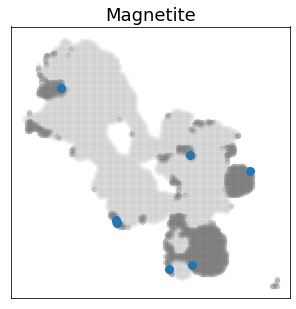

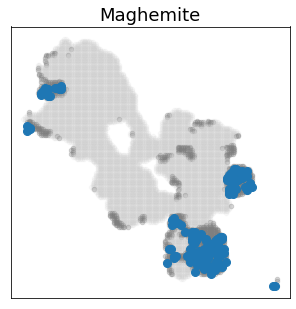

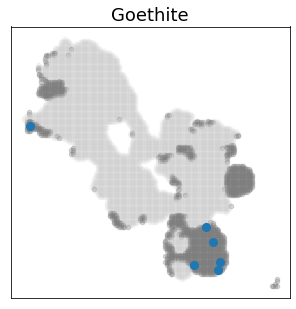

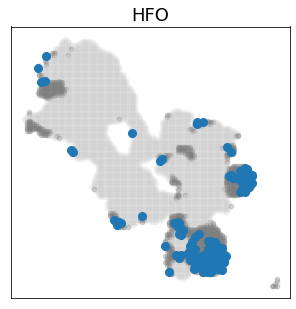

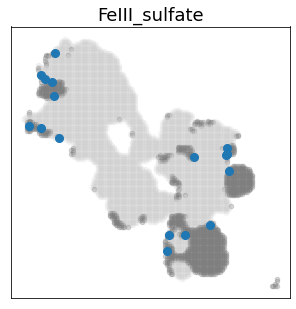

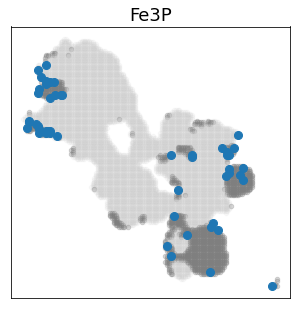

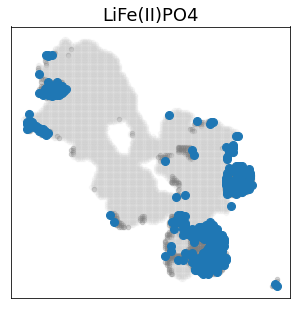

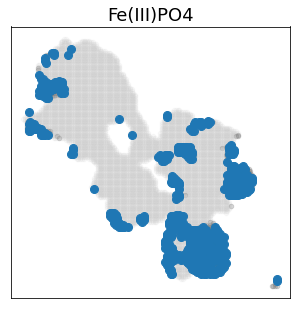

In [36]:
for c in range(len(unique_labels)):
    
    spectra_dict = normalized_spectra_dict
    colors = Colors[c]
    show_cluster = 19
    show_color = 0
    
    fig, ax = plt.subplots(figsize=(5, 5))
    for i, key in enumerate(list(spectra_dict.keys())):
        spectrum = spectra_dict[key]
        x, y = key
        if show_cluster == color_labels_sub[i]:
            if colors[i] == show_color:
                alpha = 1.0
                ms = 8
                zorder = 500000
            elif colors[i] == 14:
                alpha = 0.3
                ms = 4.5
                zorder = 1
            else:
                alpha = 0.9
                ms = 4.5
                zorder = 1
        else:
            alpha = 0.1
            ms = 4.5
            zorder = 1
        
        ax.plot(y, -x, color=plt.cm.tab20(colors[i]), marker='o', markersize=ms,
                alpha=alpha, zorder=zorder)
    remove_ticks(ax)
    
    plt.title(ref_names[c], fontsize=18)
    plt.show()